<a href="https://colab.research.google.com/github/laurefindele-o-catto/ML-Projects/blob/main/CIFAR-10/image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
# Check GPU availability
torch.cuda.is_available()

False

Defining the transformation:

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

Loading the dataset:

In [9]:
train_set = torchvision.datasets.CIFAR10(root='.', train = True, download = True, transform = transform)
test_set = torchvision.datasets.CIFAR10(root='.', train = False, download = True, transform = transform)

train_loader = DataLoader(train_set, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 100, shuffle = False)

Loading some random samples from the dataset -

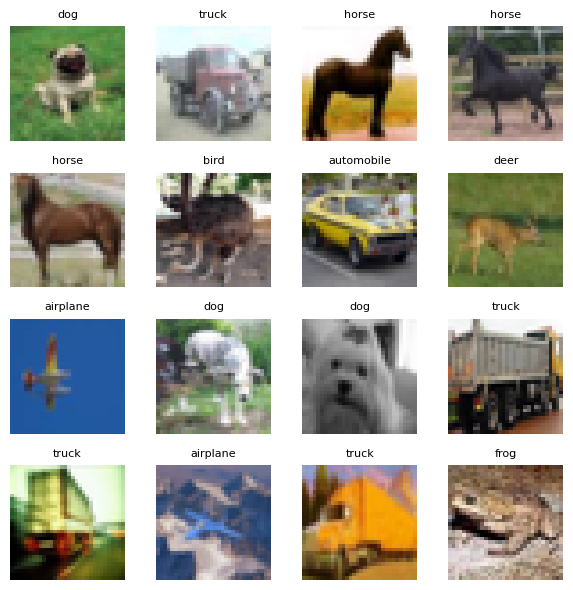

In [10]:
def unnormalize(img):
  img = img/2 + 0.5
  return img.numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:16]

fig, axes = plt.subplots(4, 4, figsize = (6,6))
for i, ax in enumerate(axes.flat):
  img = unnormalize(images[i])
  img = np.transpose(img, (1, 2, 0))
  ax.imshow(img)
  ax.set_title(train_set.classes[labels[i]], fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
class BaselineCNN1(nn.Module):
  def __init__(self):
    super(BaselineCNN1, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) #input: 3*32*32 -> 32*32*32
    #will output 32 features
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    #will take 32 features and generate 64 feautres
    self.pool = nn.MaxPool2d(2, 2)
    #reduces size 32*32 into 16*16
    #will take each 2*2 pixel square as one
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)

    self.fc = nn.Linear(128*8*8, 256)
    #will take 128*8*8 features and output 256
    #this is called flattening
    #8*8 because we've pooled twice
    self.output = nn.Linear(256, 10)
    #the final output layer, 10 outputs for 10 classes

  def forward(self, X):
    X = torch.relu(self.conv1(X))
    X = torch.relu(self.conv2(X))
    X = self.pool(X)

    X = torch.relu(self.conv3(X))
    X = torch.relu(self.conv4(X))
    X = self.pool(X)

    X = X.view(-1, 128*8*8) #flatten
    X = torch.relu(self.fc(X))
    X = self.output(X)

    return X


In [12]:
class BaselineCNN2(nn.Module):
  def __init__(self):
    super(BaselineCNN2, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)

    self.fc1 = nn.Linear(256*8*8, 256)
    self.fc2 = nn.Linear(256, 128)
    self.output = nn.Linear(128, 10)

  def forward(self, X):
    X = torch.relu(self.conv1(X))
    X = torch.relu(self.conv2(X))
    X = self.pool(X)

    X = torch.relu(self.conv3(X))
    X = torch.relu(self.conv4(X))
    X = self.pool(X)

    X = X.view(-1, 256*8*8) #flatten
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = self.output(X)

    return X


In [13]:
class BaselineCNN3(nn.Module):
  def __init__(self):
    super(BaselineCNN3, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding = 1)
    # -> 64*30*30
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 5, padding = 1)
    # -> 64*28*28
    self.pool = nn.MaxPool2d(2, 2)
    # -> 64*14*14
    self.conv4 = nn.Conv2d(128, 128, kernel_size = 5, padding = 1)
    #->128*12*12

    self.fc1 = nn.Linear(128*12*12, 256)
    self.output = nn.Linear(256, 10)

  def forward(self, X):
    X = torch.relu(self.conv1(X))
    X = torch.relu(self.conv2(X))
    X = torch.relu(self.conv3(X))
    X = self.pool(X)

    X = torch.relu(self.conv4(X))

    X = X.view(-1, 128*8*8) #flatten
    X = torch.relu(self.fc1(X))
    X = self.output(X)

    return X


In [14]:
def train_models(models, train_loader, test_loader, epochs = 20, lr = 0.01, device="cuda"):
  criterion = nn.CrossEntropyLoss()
  histories = {}

  for name, model in models.items():
    print("Training {name}")
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = 5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    # Cosine annealing: starts high, decreases gradually, then rises slightly again.
    # Helps models converge better than a fixed learning rate

    train_acc_hist, test_acc_hist = [], []

    for epoch in range(epochs):
      model.train()

      correct, total, running_loss = 0, 0, 0

      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

      train_acc = 100. * correct/total
      train_acc_hist.append(train_acc)

      model.eval()
      correct, total = 0, 0

      with torch.no_grad():
        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      test_acc = 100.*correct/total
      test_acc_hist.append(test_acc)

      scheduler.step()

      print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    histories[name] = (train_acc_hist, test_acc_hist)

  return histories

In [17]:
initial_models = {
    "BaselineCNN1": BaselineCNN1(),
    "BaselineCNN2": BaselineCNN2(),
    "BaselineCNN3": BaselineCNN3()
                  }
device = "cuda" if torch.cuda.is_available() else "cpu"
histories = train_models(initial_models, train_loader, test_loader, epochs = 20)

Training {name}


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import matplotlib.pyplot as plt

for name, (train_hist, test_hist) in histories.items():
    plt.plot(test_hist, label=name)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.show()